# DM-34711: ApPipeWithFakes on HSC COSMOS tract 9813, July 2022

Attempt at a new baseline run using "old diffim" (before the big refactor).

* Working directory on NCSA with bps logs, pipelines, etc. is `/project/mrawls/repo-main-logs/DM-34711`
* Templates are in `u/mrawls/DM-34711/templates`
* Final processing of HiTS 2015 is in `u/mrawls/DM-34711/hsc9813-fakes`
* Postgres schema is `mrawls_DM34711`

For ApTemplate.yaml:
```
inCollection: HSC/raw/RC2/9813,HSC/calib,HSC/masks,refcats,skymaps
dataQuery: "instrument='HSC' AND skymap='hsc_rings_v1' AND band IN ('g', 'r', 'i', 'z', 'y')"
```
For ApPipeWithFakes.yaml:
```
inCollection: u/mrawls/DM-34711/templates,HSC/raw/RC2/9813,HSC/calib,HSC/masks,refcats,skymaps
dataQuery: "instrument='HSC' AND skymap='hsc_rings_v1' AND band IN ('g', 'r', 'i', 'z', 'y')"
```

About 14% of quanta failed calibrateTask. DM-27013 (Gaia DR2 as an astrometric reference catalog) was never fully applied as the HSC default, and tickets exist to explore how to best remedy this (DM-27858, DM-30993). The basic problem seems to be that HSC exposures are long and full of faint sources, so it is a bad match for the magnitude range of Gaia catalog sources. A naive magnitude cut doesn't fix the problem, but a thoughtful S/N cut - perhaps tailored to exposure time, saturation level, or estimated flux zeropoints for a one-second exposure - may be able to remedy the issue. The problem is worst in bluer bands; next to no g-band quanta survived, but most z-band quanta did.

Nevertheless, here are results from the quanta that _did not_ fail calibrateTask!

In [1]:
%matplotlib notebook

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import importlib
import pandas as pd

from astropy.coordinates import SkyCoord
import astropy.units as u

import lsst.geom
import lsst.daf.butler as dafButler
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig

sys.path.append('/project/mrawls/ap_pipe-notebooks/')
import diaObjectAnalysis as doa
import apdbPlots as pla
import plotLightcurve as plc
import coaddAnalysis as coa

Overriding default configuration file with /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-4.1.0/Linux64/dustmaps_cachedata/g41a3ec361e+ac198e9f13/config/.dustmapsrc


In [ ]:
# Only if you change anything in the code imported above
importlib.reload(doa)
importlib.reload(pla)
importlib.reload(plc)
importlib.reload(coa)

In [2]:
repo = '/repo/main'
butler = dafButler.Butler(repo)
collections = 'u/mrawls/DM-34711/hsc9813-fakes'
instrument = 'HSC'
skymap = 'hsc_rings_v1'
schema = 'mrawls_DM34711'

In [3]:
badFlagList = ['base_PixelFlags_flag_bad',
               'base_PixelFlags_flag_suspect',
               'base_PixelFlags_flag_saturatedCenter',
               'base_PixelFlags_flag_interpolated',
               'base_PixelFlags_flag_interpolatedCenter',
               'base_PixelFlags_flag_edge',
              ]

In [4]:
objTable, srcTable, goodObj, goodSrc = pla.loadTables(repo,
                                                      dbType='postgres',
                                                      dbName='lsstdevapdb1',
                                                      schema=schema,
                                                      gen='gen3',
                                                      instrument=instrument,
                                                      badFlagList=badFlagList)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
srcTable = pla.addVisitCcdToSrcTable(srcTable, instrument=instrument, gen='gen3', butler=butler)
flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = pla.makeSrcTableFlags(srcTable, objTable,
                                                                               badFlagList=badFlagList,
                                                                               gen='gen3',
                                                                               instrument=instrument,
                                                                               repo=repo)

<IPython.core.display.Javascript object>


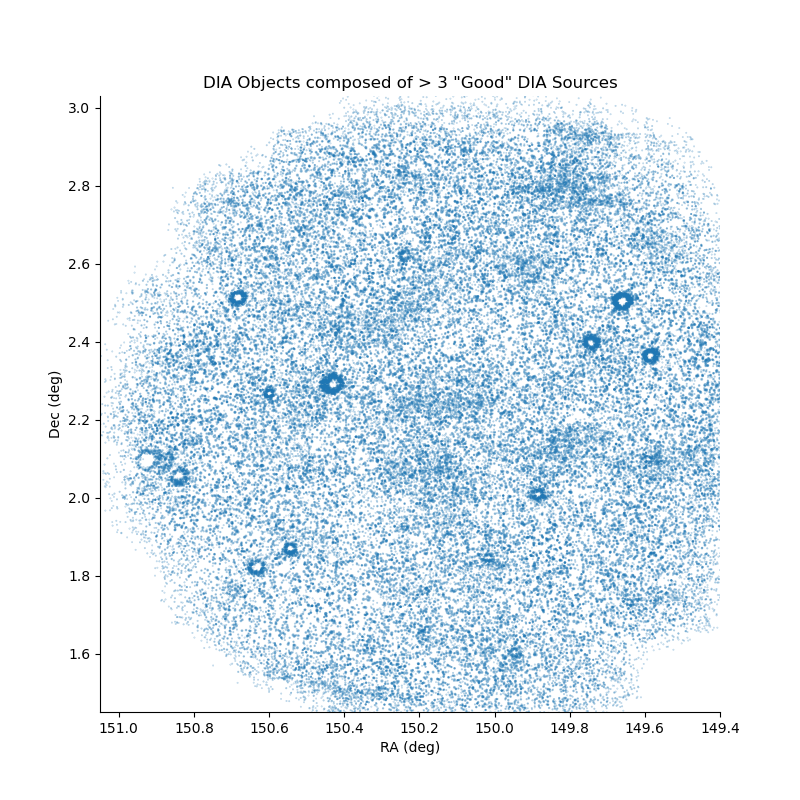

Text(0.5, 1.0, 'DIA Objects composed of > 3 "Good" DIA Sources')

In [6]:
fig = plt.figure(figsize=(8,8))

xlim = (151.05, 149.40)
ylim = (1.45, 3.03)
cutoff = 3  # only plot DIA Objects composed of cutoff or more DIA Sources

ax = fig.add_subplot(111)
plt.setp(ax, xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodObj.loc[goodObj['nDiaSources'] > cutoff, 'ra'], goodObj.loc[goodObj['nDiaSources'] > cutoff, 'decl'], 
           c='C0', s=goodObj.loc[goodObj['nDiaSources'] > cutoff, 'nDiaSources']/10, marker='.', alpha=0.4)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title(f'DIA Objects composed of > {cutoff} "Good" DIA Sources')

In [16]:
fig = plt.figure(figsize=(8,8))

xlim = (151.05, 149.40)
ylim = (1.45, 3.03)
cutoff = 0  # only plot DIA Objects composed of cutoff or more DIA Sources

ax = fig.add_subplot(111)
plt.setp(ax, xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodObj.loc[goodObj['nDiaSources'] > cutoff, 'ra'], goodObj.loc[goodObj['nDiaSources'] > cutoff, 'decl'], 
           c='C0', s=goodObj.loc[goodObj['nDiaSources'] > cutoff, 'nDiaSources']/10, marker='.', alpha=0.4)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title(f'All DIA Objects composed of any number of "Good" DIA Sources')

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'All DIA Objects composed of any number of "Good" DIA Sources')

<IPython.core.display.Javascript object>


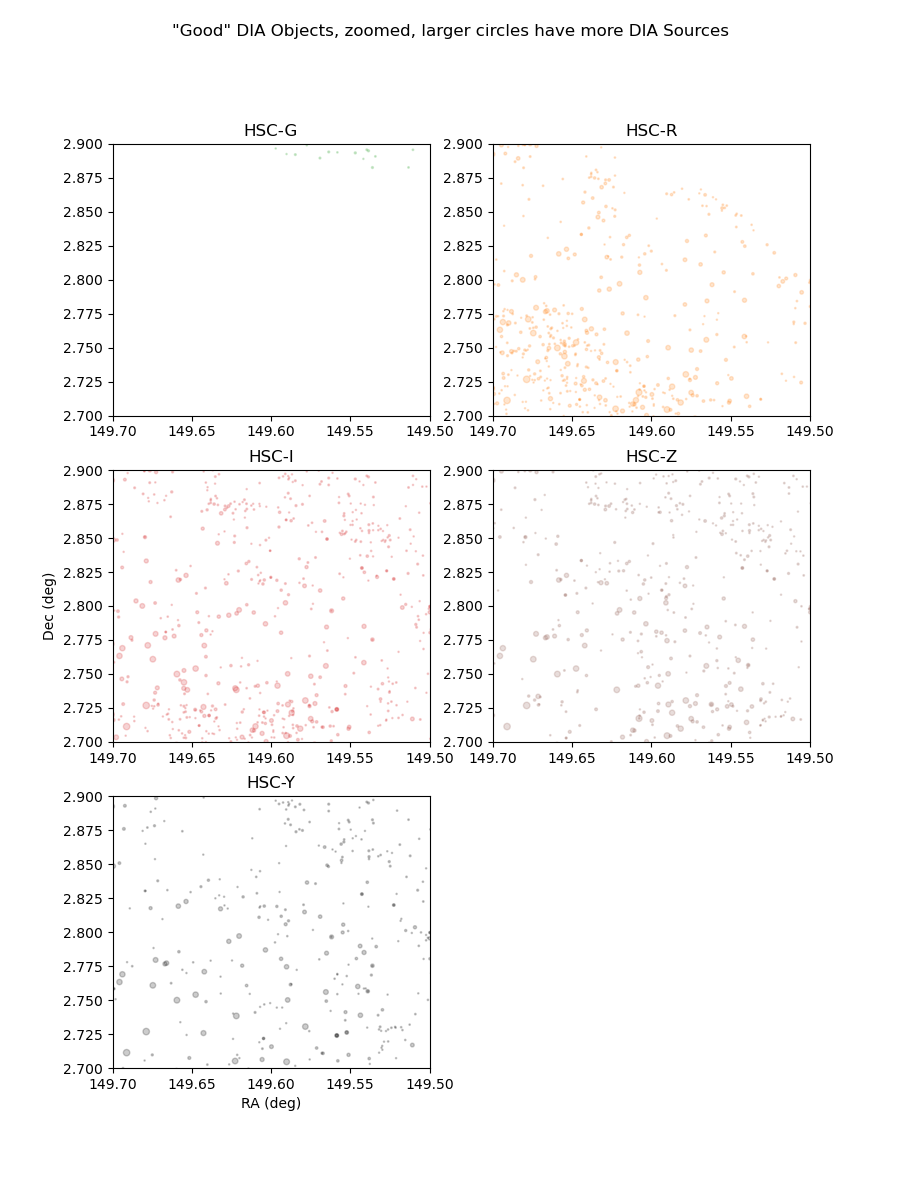

In [20]:
fig, axs = plt.subplots(3, 2, figsize=(9, 12))

fig.suptitle('"Good" DIA Objects, zoomed, larger circles have more DIA Sources')

nSrc = 2  # threshold for which DIA Objects to plot (only those with > nSrc constituent DIA Sources)

axG = axs[0, 0]
axR = axs[0, 1]
axI = axs[1, 0]
axZ = axs[1, 1]
axY = axs[2, 0]

ax0 = axs[2, 1]
ax0.axis('off')

axList = [axG, axR, axI, axZ, axY]

xlim = [149.7, 149.5]
ylim = [2.7, 2.9]
#xlim = [150.5, 150.1]
#ylim = [2.0, 2.2]
plt.setp(axs, xlim=xlim, ylim=ylim)

goodGFilter = (goodObj['nDiaSources'] > nSrc) & (goodObj['gPSFluxMean'] > 0)
goodRFilter = (goodObj['nDiaSources'] > nSrc) & (goodObj['rPSFluxMean'] > 0)
goodIFilter = (goodObj['nDiaSources'] > nSrc) & (goodObj['iPSFluxMean'] > 0)
goodZFilter = (goodObj['nDiaSources'] > nSrc) & (goodObj['zPSFluxMean'] > 0)
goodYFilter = (goodObj['nDiaSources'] > nSrc) & (goodObj['yPSFluxMean'] > 0)

goodFilterList = [goodGFilter, goodRFilter, goodIFilter, goodZFilter, goodYFilter]

axY.set_xlabel('RA (deg)')
axI.set_ylabel('Dec (deg)')

axG.set_title('HSC-G')
axR.set_title('HSC-R')
axI.set_title('HSC-I')
axZ.set_title('HSC-Z')
axY.set_title('HSC-Y')

colorList = ['C2', 'C1', 'C3', 'C5', 'k']

for ax, goodFilter, color in zip(axList, goodFilterList, colorList):
    ax.scatter(goodObj.loc[goodFilter, 'ra'],
               goodObj.loc[goodFilter, 'decl'],
               s=goodObj.loc[goodFilter, 'nDiaSources'], c=color, marker='.', alpha=0.2)

In [10]:
bandList = ['g', 'r', 'i', 'z', 'y']
colorList = ['C2', 'C1', 'C3', 'C5', 'k']

<IPython.core.display.Javascript object>


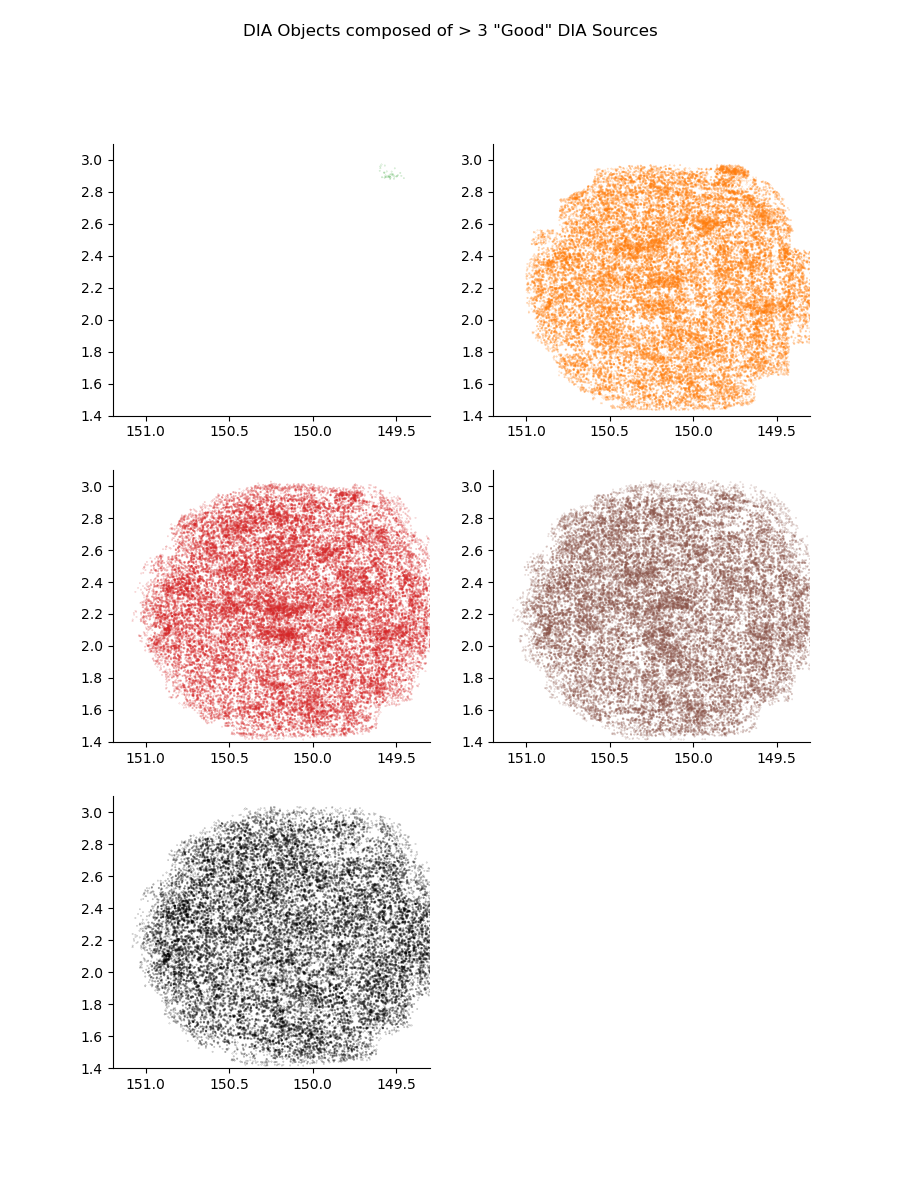

In [21]:
fig, axs = plt.subplots(3, 2, figsize=(9, 12))

axG = axs[0, 0]
axR = axs[0, 1]
axI = axs[1, 0]
axZ = axs[1, 1]
axY = axs[2, 0]
#axHits = axs[2, 1]

ax0 = axs[2, 1]
ax0.axis('off')

axList = [axG, axR, axI, axZ, axY]
colorList = ['C2', 'C1', 'C3', 'C5', 'k']

xlim = (151.2, 149.3)
ylim = (1.4, 3.1)
plt.setp(axs, xlim=xlim, ylim=ylim)


### DIA OBJECTS ###

nSrc = 3  # threshold for which DIA Objects to plot (only those with > nSrc constituent DIA Sources)
fig.suptitle(f'DIA Objects composed of > {nSrc} "Good" DIA Sources')

goodGFilter = (goodObj['nDiaSources'] > nSrc) & (goodObj['gPSFluxMean'] > 0)
goodRFilter = (goodObj['nDiaSources'] > nSrc) & (goodObj['rPSFluxMean'] > 0)
goodIFilter = (goodObj['nDiaSources'] > nSrc) & (goodObj['iPSFluxMean'] > 0)
goodZFilter = (goodObj['nDiaSources'] > nSrc) & (goodObj['zPSFluxMean'] > 0)
goodYFilter = (goodObj['nDiaSources'] > nSrc) & (goodObj['yPSFluxMean'] > 0)

filterList = [goodGFilter, goodRFilter, goodIFilter, goodZFilter, goodYFilter]

for ax, filtered, color in zip(axList, filterList, colorList):
    ax.scatter(goodObj.loc[filtered, 'ra'], goodObj.loc[filtered, 'decl'], c=color, marker='.', alpha=0.4,
               s=goodObj.loc[(goodObj['nDiaSources'] > cutoff) & (filtered), 'nDiaSources']/20)


for ax in axList:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

<IPython.core.display.Javascript object>


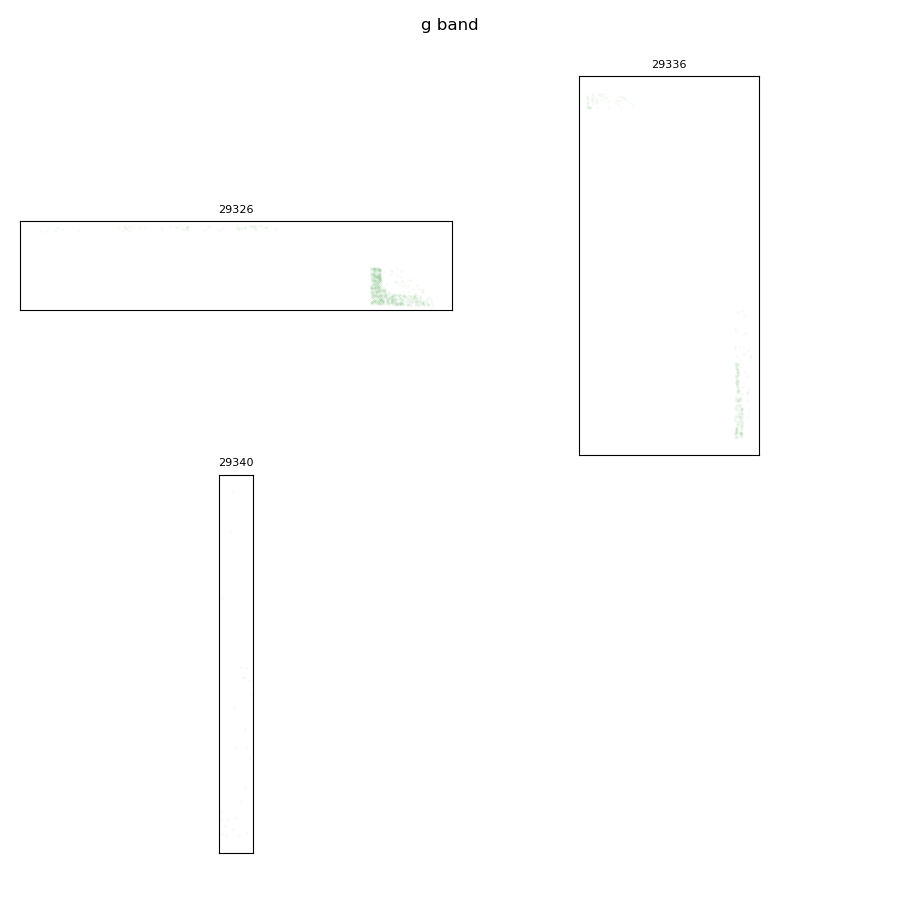

<IPython.core.display.Javascript object>


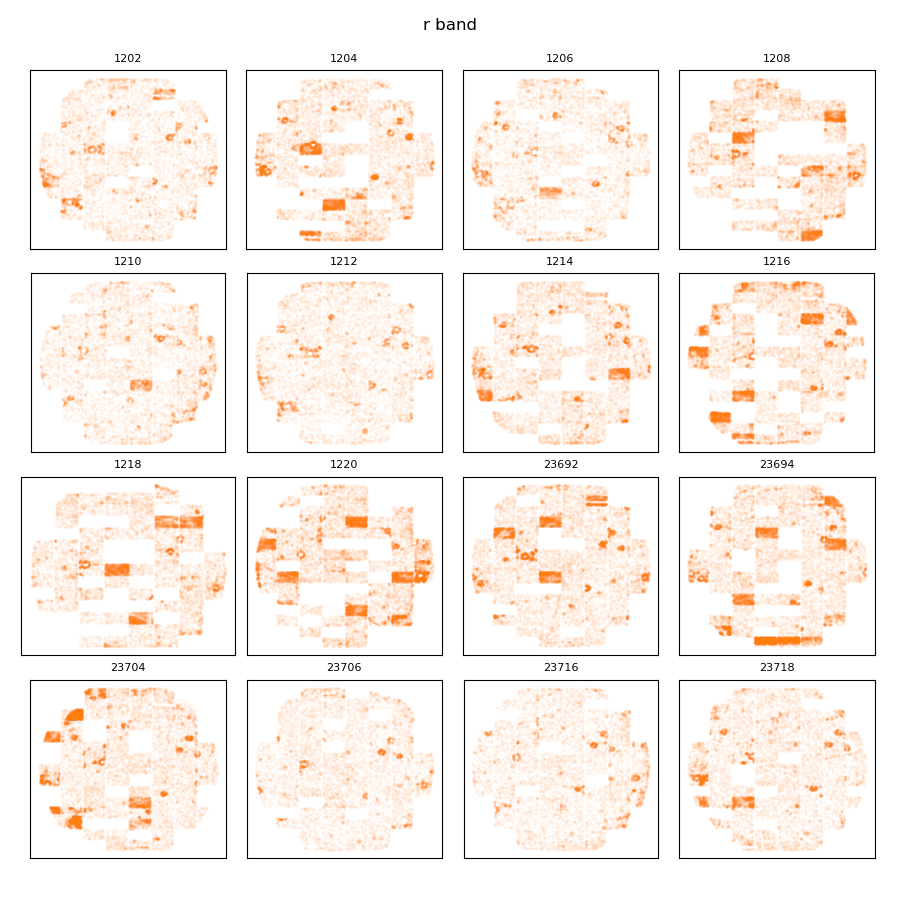

<IPython.core.display.Javascript object>


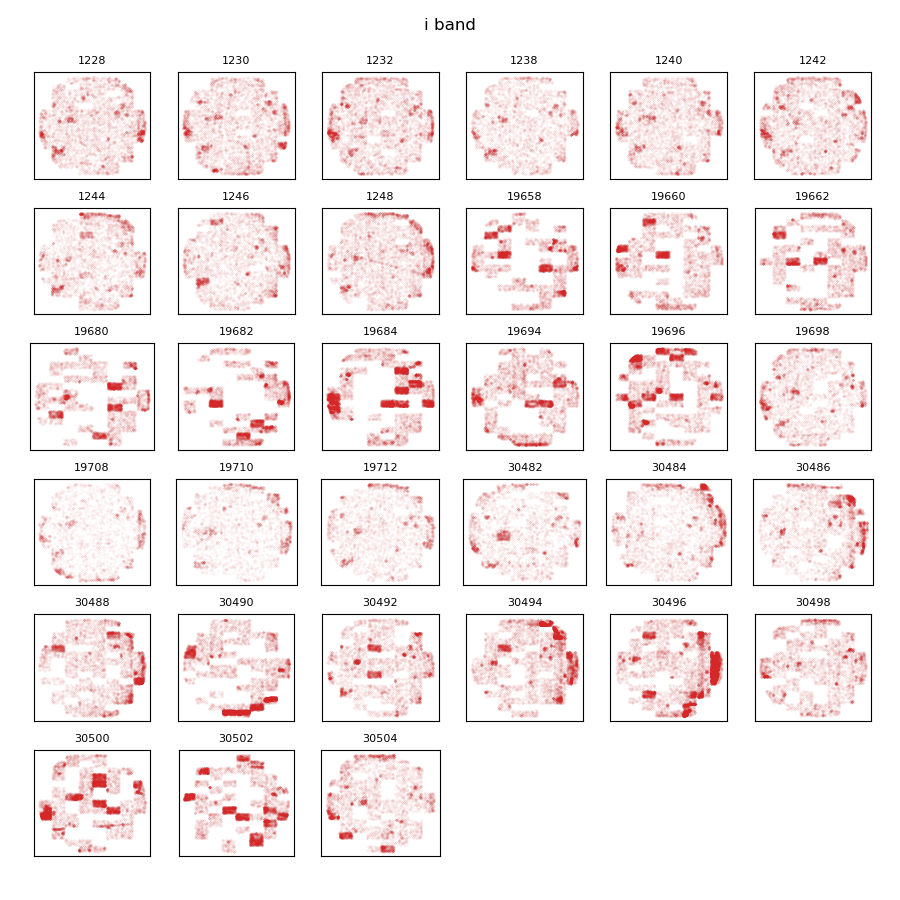

<IPython.core.display.Javascript object>


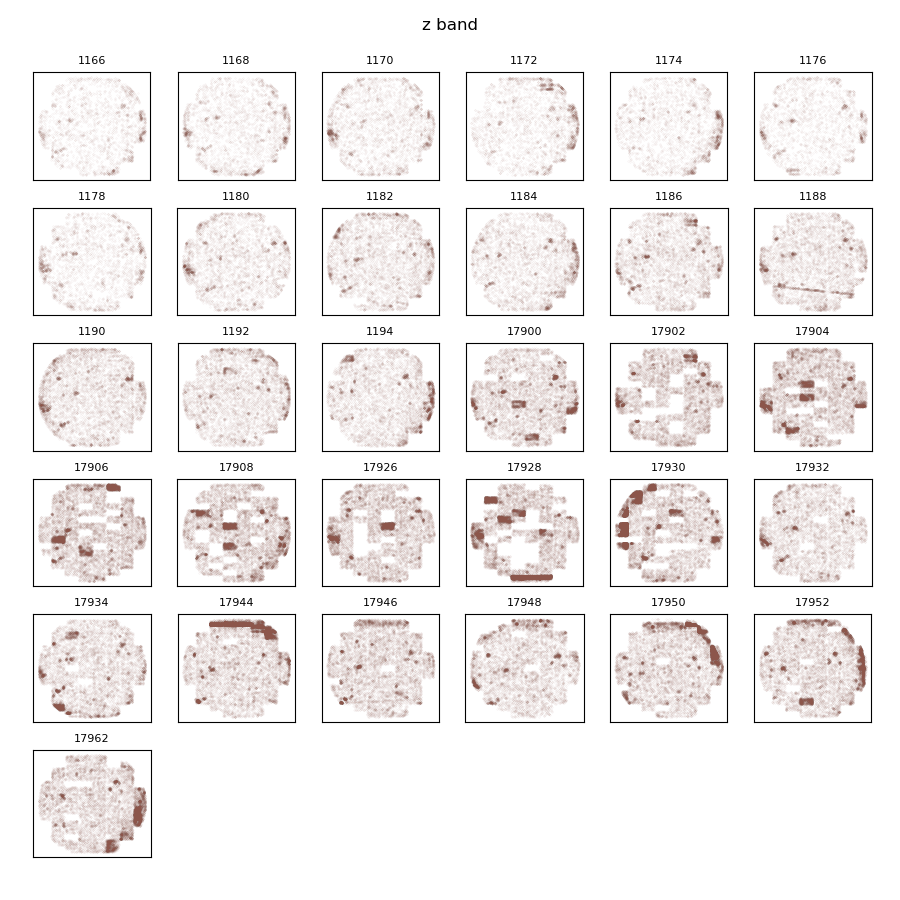

<IPython.core.display.Javascript object>


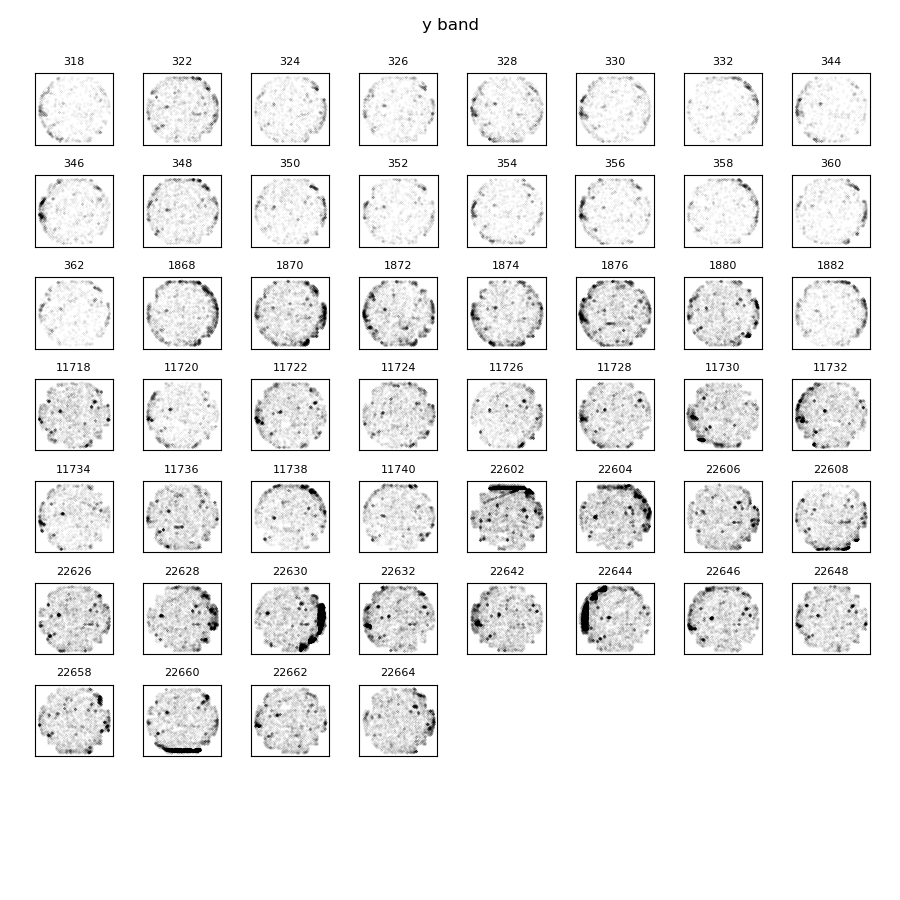

In [11]:
for band, color in zip(bandList, colorList):
    pla.plotDiaSourcesOnSkyGrid(repo, goodSrc.loc[goodSrc['filterName'] == band], title=band+' band', color=color)

<IPython.core.display.Javascript object>


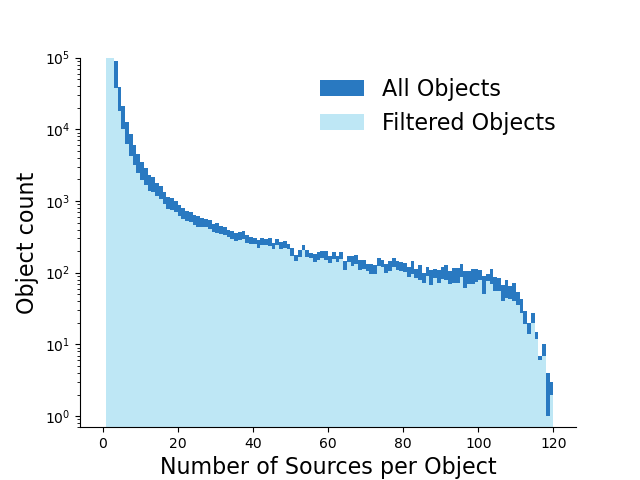

In [18]:
hist = doa.plotDiaObjectHistogram(objTable, goodObj)

<IPython.core.display.Javascript object>


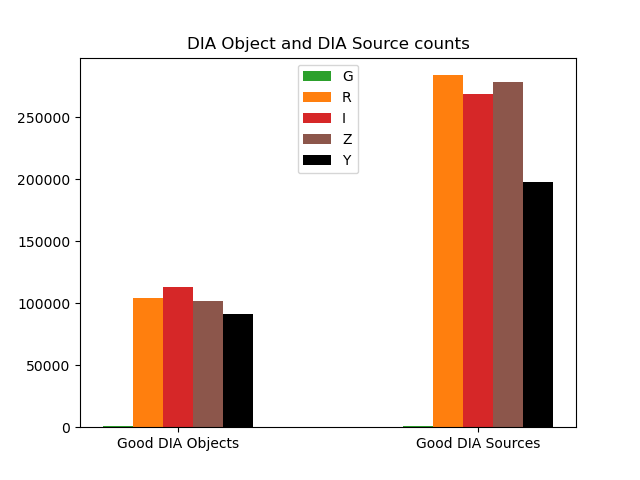

Text(0.5, 1.0, 'DIA Object and DIA Source counts')

In [19]:
fig, ax = plt.subplots()
barLabels = ['Good DIA Objects', 'Good DIA Sources']
xbar = np.array([0, 1])
width = 0.2

#hitsObjCompare = (goodObjHits['decl'] > 0)
#hitsSrcCompare = (goodSrcHits['decl'] > 0)

goodObjG = goodObj.loc[goodObj['gPSFluxMean'] > 0]
goodObjR = goodObj.loc[goodObj['rPSFluxMean'] > 0]
goodObjI = goodObj.loc[goodObj['iPSFluxMean'] > 0]
goodObjZ = goodObj.loc[goodObj['zPSFluxMean'] > 0]
goodObjY = goodObj.loc[goodObj['yPSFluxMean'] > 0]

goodSrcG = goodSrc.loc[goodSrc['filterName'] == 'g']
goodSrcR = goodSrc.loc[goodSrc['filterName'] == 'r']
goodSrcI = goodSrc.loc[goodSrc['filterName'] == 'i']
goodSrcZ = goodSrc.loc[goodSrc['filterName'] == 'z']
goodSrcY = goodSrc.loc[goodSrc['filterName'] == 'y']

ax.bar(xbar - width, [len(goodObjG), len(goodSrcG)], width/2, label='G', color='C2')
ax.bar(xbar - width/2, [len(goodObjR), len(goodSrcR)], width/2, label='R', color='C1')
ax.bar(xbar, [len(goodObjI), len(goodSrcI)], width/2, label='I', color='C3')
ax.bar(xbar + width/2, [len(goodObjZ), len(goodSrcZ)], width/2, label='Z', color='C5')
ax.bar(xbar + width, [len(goodObjY), len(goodSrcY)], width/2, label='Y', color='k')
#ax.bar(xbar + width + width/2, [len(goodObjHits[hitsObjCompare]), len(goodSrcHits[hitsSrcCompare])],
#       width/2, label='HiTS', color='C0')

plt.legend(loc='upper center')
ax.set_xticks([0, 1])
labels = ax.set_xticklabels(barLabels)
plt.title('DIA Object and DIA Source counts')

<IPython.core.display.Javascript object>


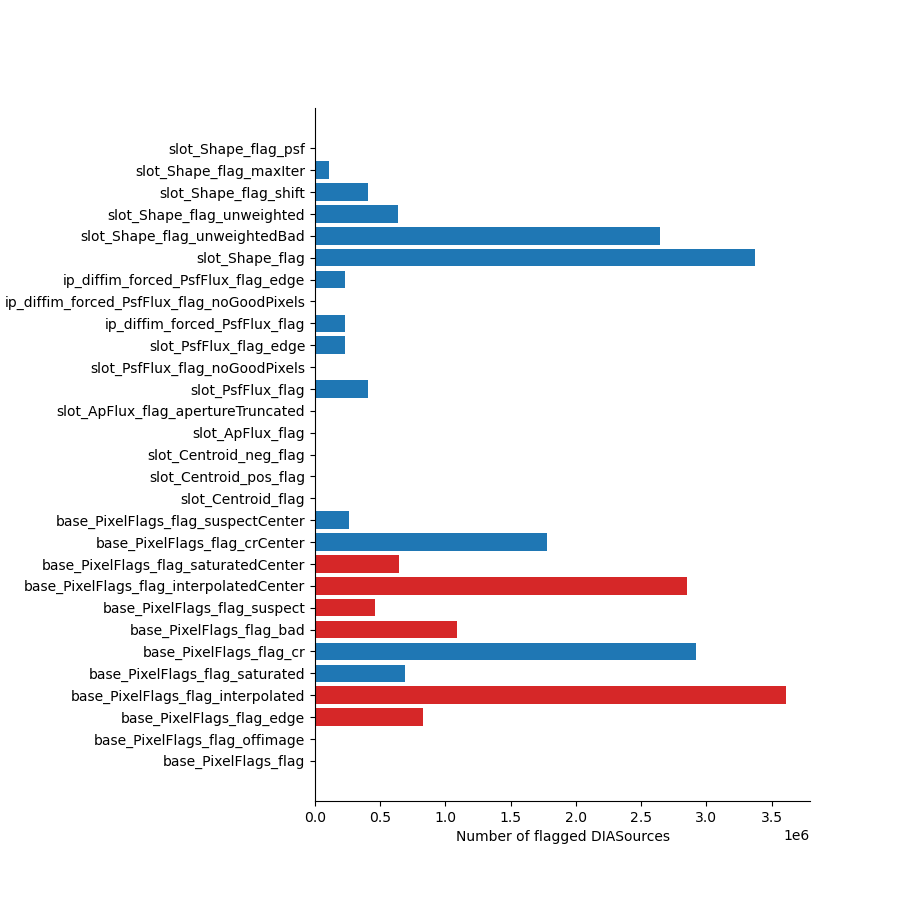

In [22]:
pla.plotFlagHist(srcTable, badFlagList=badFlagList)

<IPython.core.display.Javascript object>


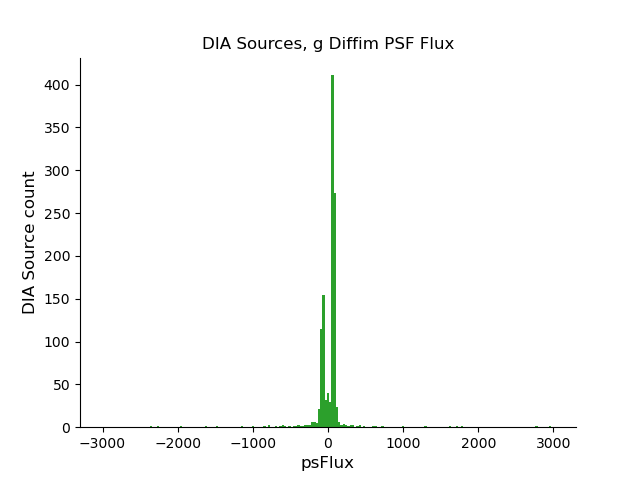

<IPython.core.display.Javascript object>


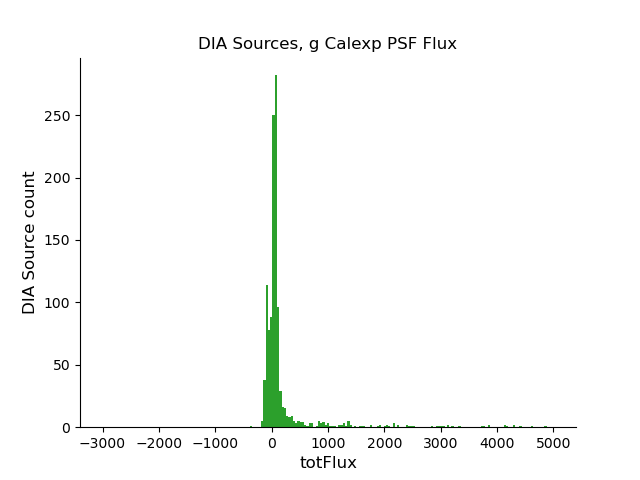

<IPython.core.display.Javascript object>


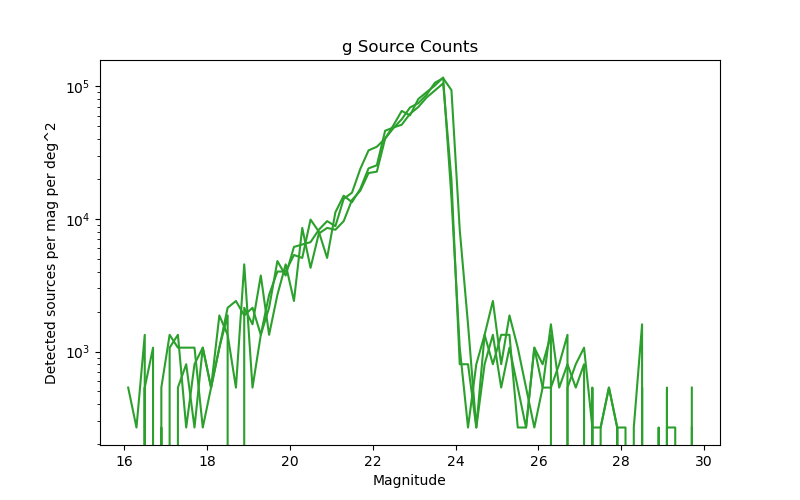

<IPython.core.display.Javascript object>


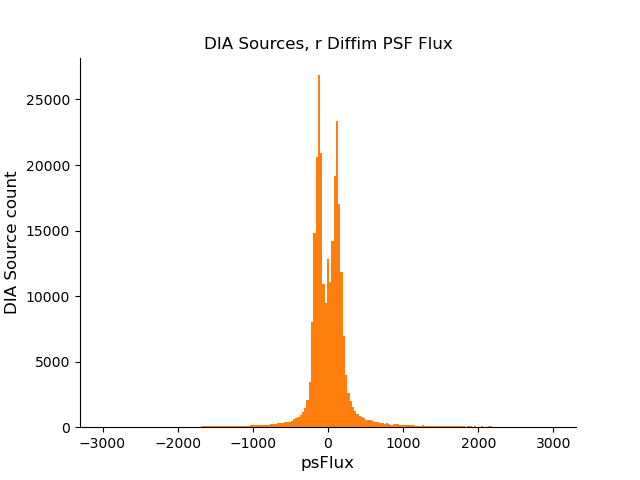

<IPython.core.display.Javascript object>


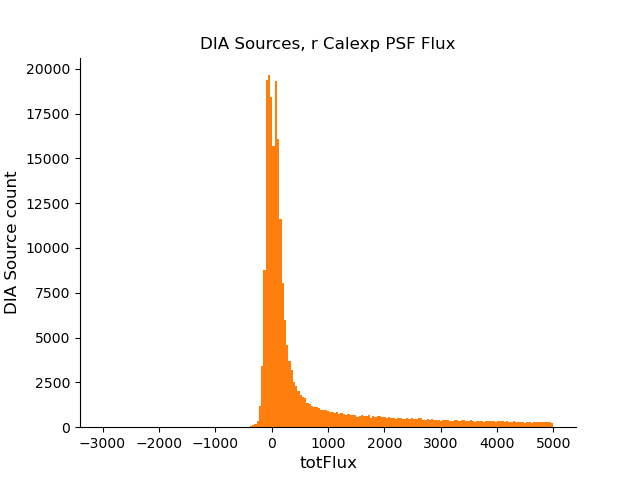

<IPython.core.display.Javascript object>


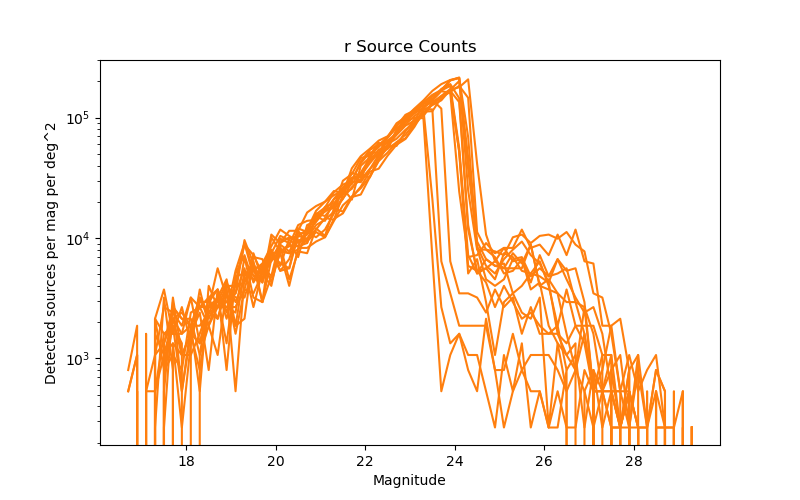

<IPython.core.display.Javascript object>


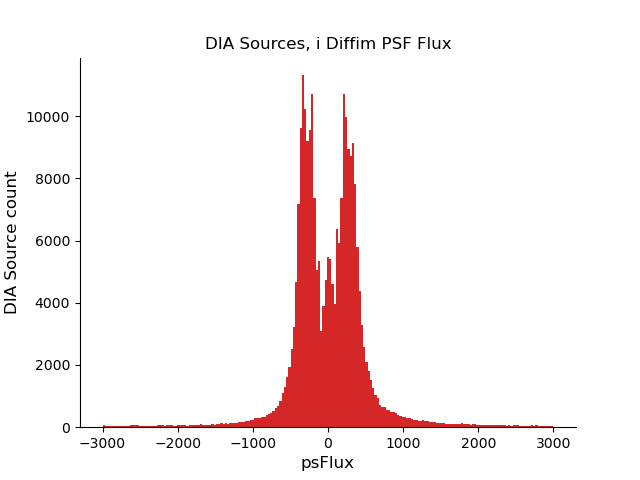

<IPython.core.display.Javascript object>


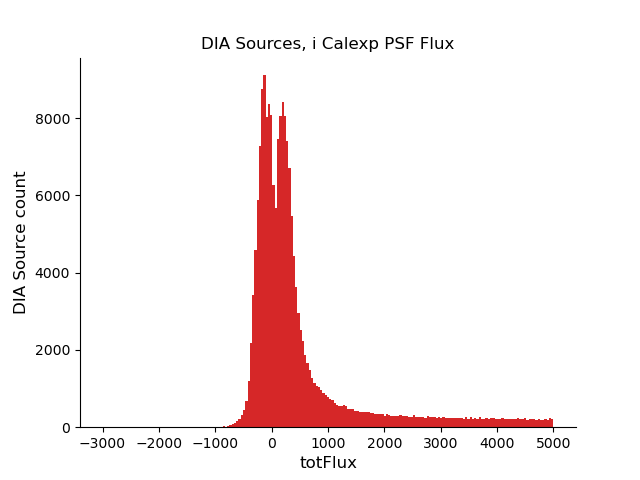

/project/mrawls/ap_pipe-notebooks/apdbPlots.py:914: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8, 5))


<IPython.core.display.Javascript object>


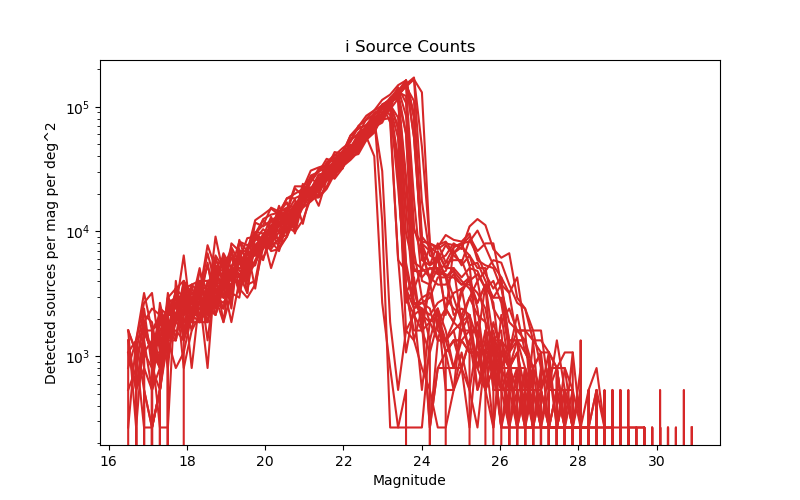

<IPython.core.display.Javascript object>


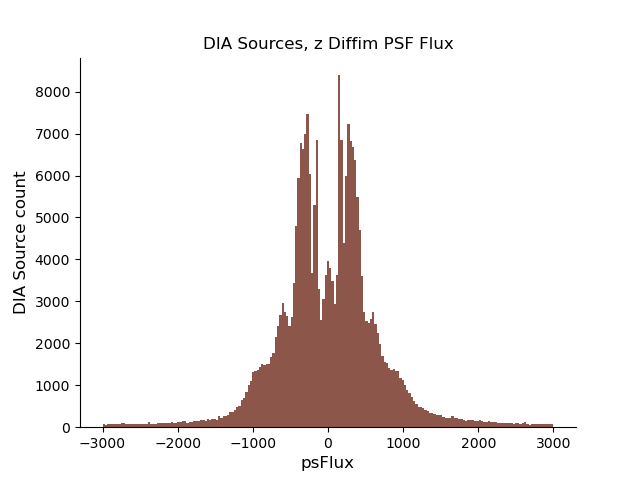

<IPython.core.display.Javascript object>


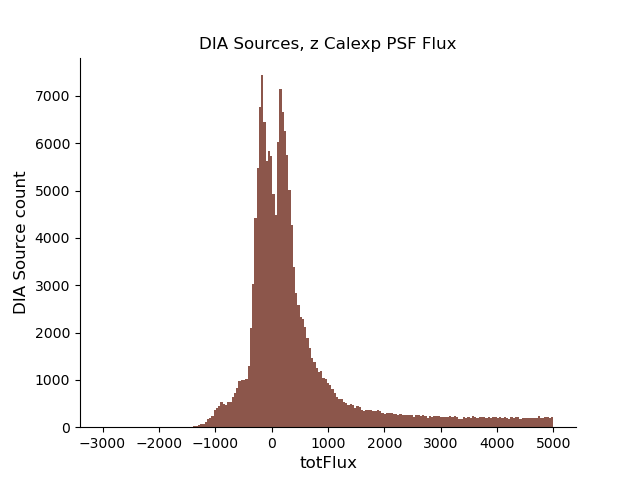

<IPython.core.display.Javascript object>


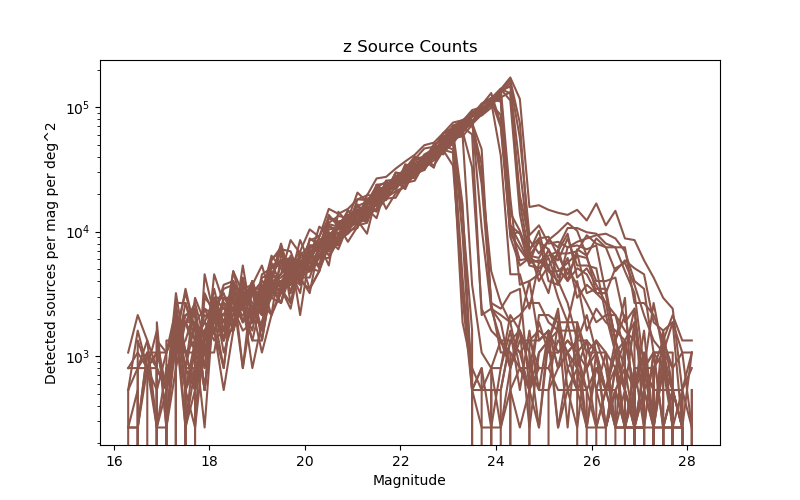

<IPython.core.display.Javascript object>


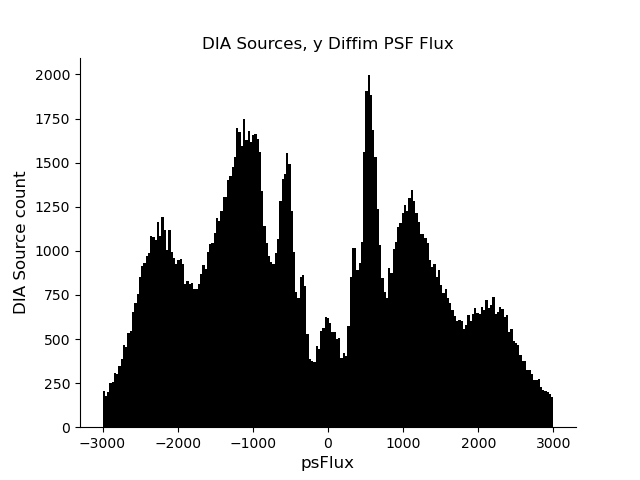

<IPython.core.display.Javascript object>


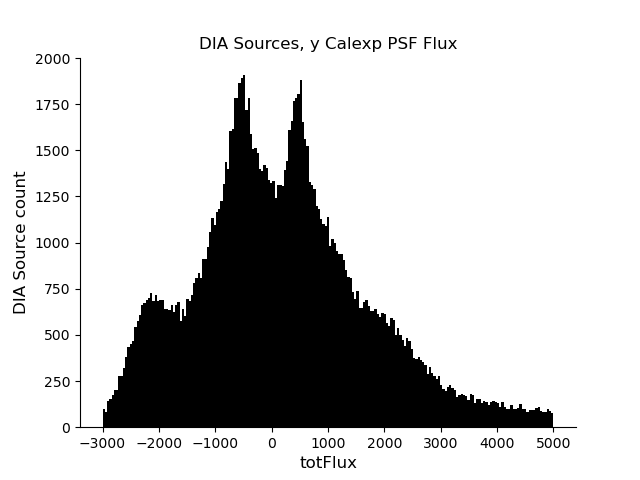

<IPython.core.display.Javascript object>


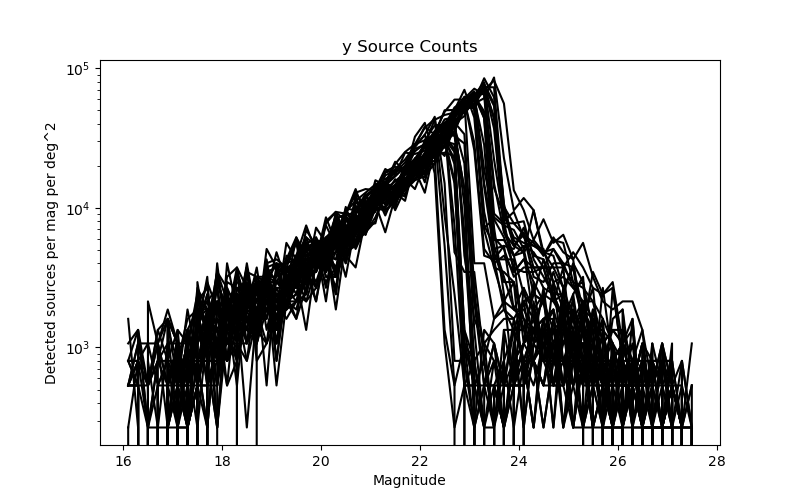

In [24]:
bandList = ['g', 'r', 'i', 'z', 'y']
colorList = ['C2', 'C1', 'C3', 'C5', 'k']
collection = collections

for band, color in zip(bandList, colorList):
    pla.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == band], fluxType='psFlux',
                        title=f'DIA Sources, {band} Diffim PSF Flux', color1=color, binmin=-3e3, binmax=3e3)
    pla.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == band], fluxType='totFlux',
                        title=f'DIA Sources, {band} Calexp PSF Flux', color1=color, binmin=-3e3, binmax=5e3)
    pla.source_magnitude_histogram(repo, goodSrc, band, 'HSC', collection)

## Look at fakes

In [26]:
tractList = [9813]
dfs = [butler.get('fakes_fakeSourceCat', collections=collections,
                 instrument=instrument, skymap=skymap, tract=tract) for tract in tractList]
allInjectedFakes = pd.concat(dfs, ignore_index=True)

In [27]:
allInjectedFakes

fakeId       dec        ra  isVisitSource  \
0      9722566843788874346  0.030411  2.621597           True   
1     13293227834158345215  0.034815  2.621040           True   
2     13797539844424859571  0.042081  2.603423           True   
3     13047102902802776076  0.040334  2.636729           True   
4     12163008760316188521  0.033896  2.629257           True   
...                    ...       ...       ...            ...   
8858   9543190124636951715  0.043717  2.610436          False   
8859  10132768081127925260  0.055644  2.621685          False   
8860   9749989945644541037  0.040447  2.606848          False   
8861  13519247332700417576  0.036272  2.603944          False   
8862   9285569630809723139  0.021855  2.621238          False   

      isTemplateSource      u_mag      g_mag      r_mag      i_mag      z_mag  \
0                False  25.160898  25.160898  25.160898  25.160898  25.160898   
1                False  20.642687  20.642687  20.642687  20.642687  20.642687   
2                False  23.876662  23.876662  23.876662  23.876662  23.876662   
3                False  25.118767  25.118767  25.118767  25.118767  25.118767   
4                False  23.367207  23.367207  23.367207  23.367207  23.367207   
...                ...        ...        ...        ...        ...        ...   
8858              True  20.013189  20.013189  20.013189  20.013189  20.013189   
8859              True  21.096544  21.096544  21.096544  21.096544  21.096544   
8860              True  24.345681  24.345681  24.345681  24.345681  24.345681   
8861              True  23.850171  23.850171  23.850171  23.850171  23.850171   
8862              True  23.410654  23.410654  23.410654  23.410654  23.410654   

          y_mag  disk_semimajor  bulge_semimajor  disk_n  bulge_n  \
0     25.160898             1.0              1.0     1.0      1.0   
1     20.642687             1.0              1.0     1.0      1.0   
2     23.876662             1.0              1.0     1.0      1.0   
3     25.118767             1.0              1.0     1.0      1.0   
4     23.367207             1.0              1.0     1.0      1.0   
...         ...             ...              ...     ...      ...   
8858  20.013189             1.0              1.0     1.0      1.0   
8859  21.096544             1.0              1.0     1.0      1.0   
8860  24.345681             1.0              1.0     1.0      1.0   
8861  23.850171             1.0              1.0     1.0      1.0   
8862  23.410654             1.0              1.0     1.0      1.0   

      disk_axis_ratio  bulge_axis_ratio  disk_pa  bulge_pa sourceType  
0                 1.0               1.0      0.0       1.0       star  
1                 1.0               1.0      0.0       1.0       star  
2                 1.0               1.0      0.0       1.0       star  
3                 1.0               1.0      0.0       1.0       star  
4                 1.0               1.0      0.0       1.0       star  
...               ...               ...      ...       ...        ...  
8858              1.0               1.0      0.0       1.0       star  
8859              1.0               1.0      0.0       1.0       star  
8860              1.0               1.0      0.0       1.0       star  
8861              1.0               1.0      0.0       1.0       star  
8862              1.0               1.0      0.0       1.0       star  

[8863 rows x 20 columns]

In [28]:
def collectMatchedDiaSources(fakesMatchDiaSrc, maxi=-1):
    """Given a butler query of fakesMatchDiaSrc datasetRefs, create a pandas dataframe with them all.
    'All' is defined as up to maxi of them, so it doesn't take forever.
    
    If you really want all of them, set maxi to -1.
    """
    #%%time
    visitDetectorFrames = []

    i = 0

    for datasetRef in fakesMatchDiaSrc: 
        try:
            frame = butler.getDirect(datasetRef)
            # nondetected sources don't have DIASource records--so propagate metadata to all rows
            # grab a detected row
            w = frame['diaSourceId'] > 0
            if np.sum(w) == 0:
                print(f'No real sources detected in {datasetRef}')
                continue
            ccdVisitId = int(frame.loc[w,'ccdVisitId'].iloc[0])
            filterName = frame.loc[w,'filterName'].iloc[0]
            # propagate to all rows
            frame.loc[:,'ccdVisitId'] = ccdVisitId 
            frame.loc[:,'filterName'] = filterName 
        #except LookupError:
            #print(f'No data for {datasetRef}')
            #continue
        except Exception as e:
            raise(e)
        else:
            visitDetectorFrames.append(frame)
        i+=1
        if i == maxi:
            break

    matchedDiaSources = pd.concat(visitDetectorFrames)
    #print(matchedDiaSources.columns)

    matchedDiaSources.loc[:,'ra'] = np.degrees(matchedDiaSources['ra_x'])
    matchedDiaSources.loc[:,'decl'] = np.degrees(matchedDiaSources['dec'])

    return matchedDiaSources

In [29]:
fakesMatchDiaSrc = butler.registry.queryDatasets(collections=collections,
                                                 datasetType='fakes_goodSeeingDiff_matchDiaSrc')
matchedDiaSources = collectMatchedDiaSources(fakesMatchDiaSrc)

In [30]:
instrumentDataId = butler.registry.expandDataId(instrument=instrument)
packer = butler.registry.dimensions.makePacker("visit_detector", instrumentDataId)
dataId = packer.unpack(matchedDiaSources.ccdVisitId)
matchedDiaSources['visit'] = dataId['visit']
matchedDiaSources['detector'] = dataId['detector']

In [31]:
matchedDiaSources

fakeId       dec      ra_x  isVisitSource  isTemplateSource  \
0    9939403707429208445  0.025268  2.626366           True             False   
1    9225513439365763716  0.025800  2.627411           True             False   
2   11565702870030637352  0.025674  2.625184           True             False   
3   10800880439949491421  0.025470  2.626896           True             False   
4    9818378594623189143  0.025708  2.626256           True             False   
..                   ...       ...       ...            ...               ...   
26  11391766892105685470  0.046766  2.610934          False              True   
27  13335630537586934805  0.047333  2.609666          False              True   
28   9279572794090187432  0.046115  2.610535          False              True   
29  13379927270727706928  0.045226  2.609905          False              True   
30  11290262117541627302  0.045196  2.609513          False              True   

        u_mag      g_mag      r_mag      i_mag      z_mag  ...  totFluxErr  \
0   23.230648  23.230648  23.230648  23.230648  23.230648  ...         NaN   
1   20.308028  20.308028  20.308028  20.308028  20.308028  ...         NaN   
2   23.023476  23.023476  23.023476  23.023476  23.023476  ...  420.031113   
3   20.820218  20.820218  20.820218  20.820218  20.820218  ...  445.995201   
4   23.270824  23.270824  23.270824  23.270824  23.270824  ...         NaN   
..        ...        ...        ...        ...        ...  ...         ...   
26  23.516942  23.516942  23.516942  23.516942  23.516942  ...  187.252352   
27  25.823110  25.823110  25.823110  25.823110  25.823110  ...         NaN   
28  24.658377  24.658377  24.658377  24.658377  24.658377  ...         NaN   
29  23.048853  23.048853  23.048853  23.048853  23.048853  ...  190.957731   
30  25.377940  25.377940  25.377940  25.377940  25.377940  ...         NaN   

         ixx       iyy       ixy    ixxPSF    iyyPSF    ixyPSF          ra  \
0        NaN       NaN       NaN       NaN       NaN       NaN  150.479678   
1        NaN       NaN       NaN       NaN       NaN       NaN  150.539558   
2        NaN       NaN       NaN  0.268617 -0.003089 -0.003089  150.411984   
3   0.269172  0.236891 -0.016198  0.262370 -0.003017 -0.003017  150.510047   
4        NaN       NaN       NaN       NaN       NaN       NaN  150.473406   
..       ...       ...       ...       ...       ...       ...         ...   
26       NaN       NaN       NaN  0.081442 -0.004462 -0.004462  149.595480   
27       NaN       NaN       NaN       NaN       NaN       NaN  149.522837   
28       NaN       NaN       NaN       NaN       NaN       NaN  149.572619   
29       NaN       NaN       NaN  0.081246 -0.004451 -0.004451  149.536513   
30       NaN       NaN       NaN       NaN       NaN       NaN  149.514100   

    visit detector  
0     318        0  
1     318        0  
2     318        0  
3     318        0  
4     318        0  
..    ...      ...  
26  22632      103  
27  22632      103  
28  22632      103  
29  22632      103  
30  22632      103  

[410057 rows x 68 columns]

<IPython.core.display.Javascript object>


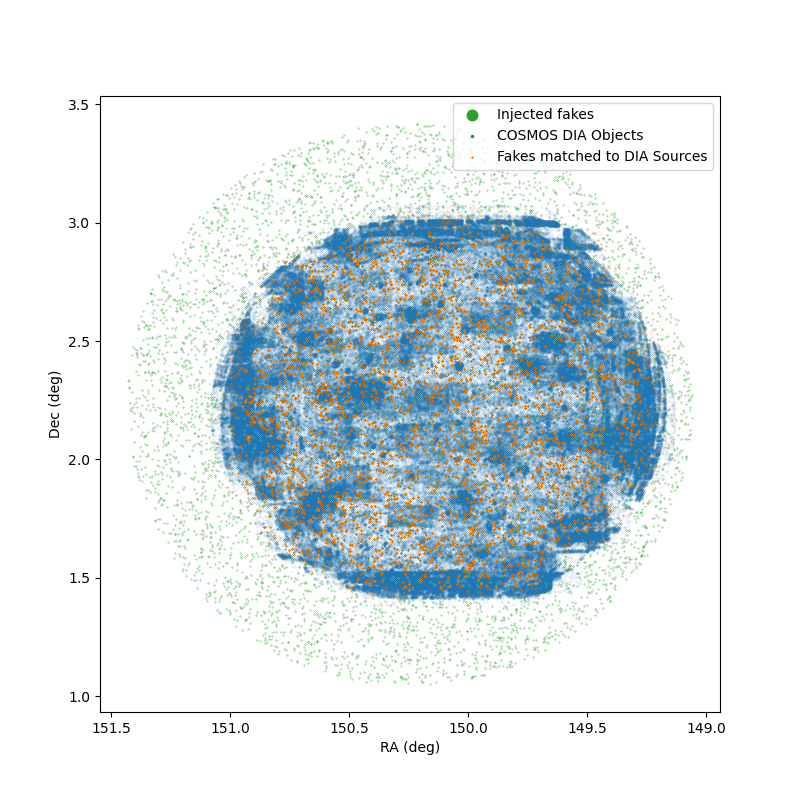

In [35]:
plt.figure(figsize=(8,8))
plt.plot(allInjectedFakes.ra*u.rad.to(u.deg), allInjectedFakes.dec*u.rad.to(u.deg),
         ls='None', marker='.', ms=0.5, label="Injected fakes", color='C2')
plt.plot(goodObj.ra, goodObj.decl, ls='None', marker='.', ms=0.1, label="COSMOS DIA Objects", color='C0')
plt.plot(matchedDiaSources.ra_x*u.rad.to(u.deg), matchedDiaSources.dec*u.rad.to(u.deg), ls='None', marker='.',
         ms=0.05, label="Fakes matched to DIA Sources", color='C1')
plt.gca().invert_xaxis()
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.legend(markerscale=30)

<IPython.core.display.Javascript object>


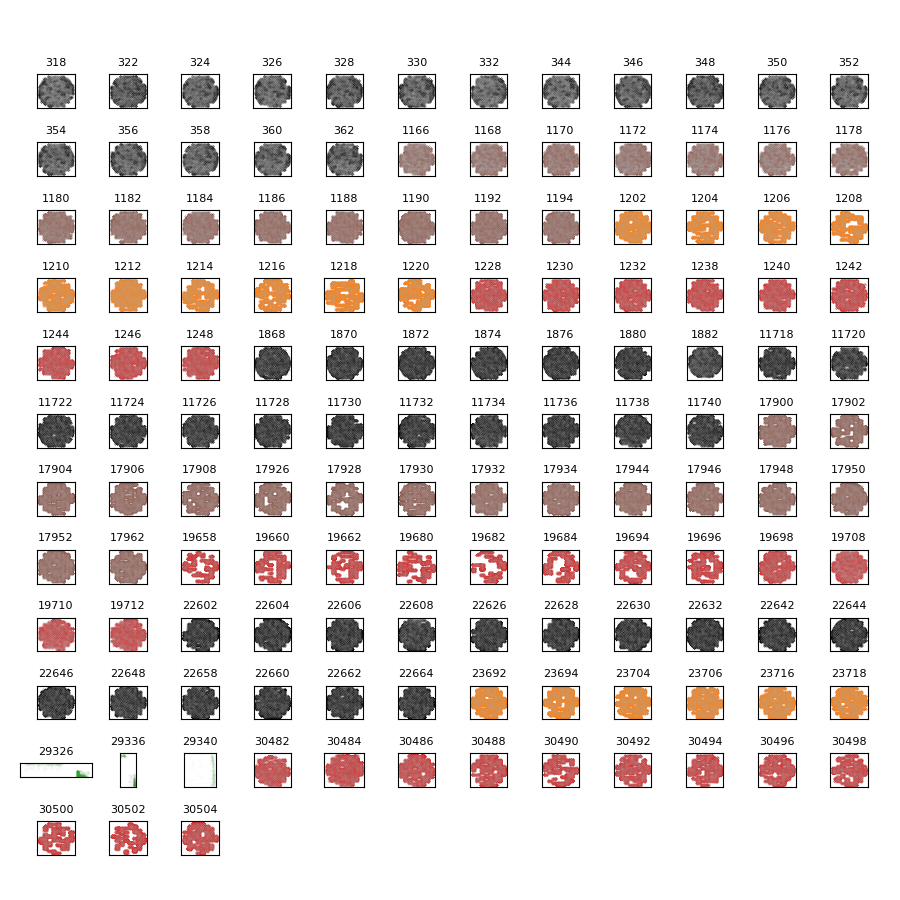

visit 318: 17210 DIA Sources, 3540 matched injected fakes
visit 322: 21722 DIA Sources, 3532 matched injected fakes
visit 324: 18127 DIA Sources, 3528 matched injected fakes
visit 326: 17968 DIA Sources, 3438 matched injected fakes
visit 328: 20813 DIA Sources, 3552 matched injected fakes
visit 330: 19326 DIA Sources, 3503 matched injected fakes
visit 332: 16694 DIA Sources, 3542 matched injected fakes
visit 344: 17522 DIA Sources, 3529 matched injected fakes
visit 346: 19368 DIA Sources, 3525 matched injected fakes
visit 348: 22083 DIA Sources, 3610 matched injected fakes
visit 350: 19221 DIA Sources, 3549 matched injected fakes
visit 352: 18177 DIA Sources, 3487 matched injected fakes
visit 354: 19113 DIA Sources, 3576 matched injected fakes
visit 356: 19514 DIA Sources, 3530 matched injected fakes
visit 358: 18437 DIA Sources, 3554 matched injected fakes
visit 360: 17754 DIA Sources, 3445 matched injected fakes
visit 362: 18614 DIA Sources, 3473 matched injected fakes
visit 1166: 19

In [55]:
# Plot visit-by-visit: DIA Sources (blue) and inserted fakes (orange)

sourceTablePlot = srcTable
#sourceTablePlot = goodSrc

visits = np.unique(sourceTablePlot['visit'])
nVisits = len(visits)
if np.floor(np.sqrt(nVisits)) - np.sqrt(nVisits) == 0:
    squareGridSize = int(np.sqrt(nVisits))
else:
    squareGridSize = int(np.sqrt(nVisits)) + 1

fig = plt.figure(figsize=(9, 9))
for count, visit in enumerate(np.unique(sourceTablePlot['visit'].values)):
    band = sourceTablePlot.loc[(sourceTablePlot.visit == visit), 'filterName'].iloc[0]
    color = ['C2' if band=='g' else 'C1' if band=='r' else 'C3' if band=='i' else 'C5' if band=='z' else 'k' if band=='y' else 'C0']
    #bandList = ['g', 'r', 'i', 'z', 'y']
    #colorList = ['C2', 'C1', 'C3', 'C5', 'k']
    idx = sourceTablePlot.visit == visit
    ax = fig.add_subplot(squareGridSize, squareGridSize, count + 1, aspect='equal')
    ax.scatter(sourceTablePlot.ra[idx], sourceTablePlot.decl[idx], c=color, marker='.', s=0.005, alpha=0.3)
    
    fakeSources = matchedDiaSources.loc[matchedDiaSources.visit == visit]
    ax.scatter(fakeSources.ra_x*u.rad.to(u.deg), fakeSources.dec*u.rad.to(u.deg),
               c='0.75', marker='.', s=0.02, alpha=0.3)
    
    ax.set_title(visit, size=8)
    ax.invert_xaxis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    print(f'visit {visit}: {len(sourceTablePlot.loc[sourceTablePlot.visit == visit])} DIA Sources, {len(fakeSources)} matched injected fakes')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0)

## SNR distributions for diffim fluxes and forced source photometry fluxes

In [6]:
srcTable['psFluxSNR'] = srcTable.psFlux / srcTable.psFluxErr
srcTable['totFluxSNR'] = srcTable.totFlux / srcTable.totFluxErr

<IPython.core.display.Javascript object>


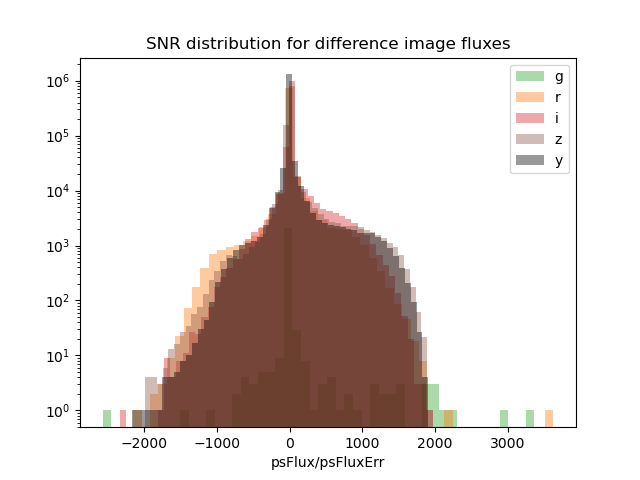

Text(0.5, 0, 'psFlux/psFluxErr')

In [13]:
bandList = ['g', 'r', 'i', 'z', 'y']
colorList = ['C2', 'C1', 'C3', 'C5', 'k']
plt.figure()
plt.yscale('log')
for band, color in zip(bandList, colorList):
    psFluxHist = plt.hist(srcTable.loc[srcTable.filterName==band, 'psFluxSNR'], bins=50, color=color, alpha=0.4, label=band)
plt.legend()
plt.title('SNR distribution for difference image fluxes')
plt.xlabel('psFlux/psFluxErr')

<IPython.core.display.Javascript object>


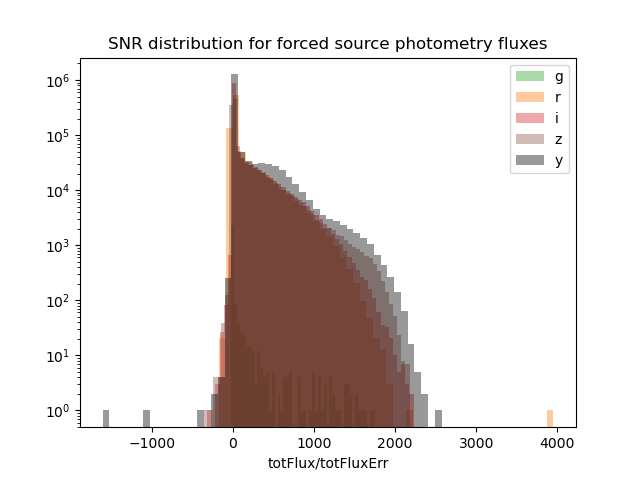

Text(0.5, 0, 'totFlux/totFluxErr')

In [14]:
plt.figure()
plt.yscale('log')
for band, color in zip(bandList, colorList):
    totFluxHist = plt.hist(srcTable.loc[srcTable.filterName==band, 'totFluxSNR'], bins=50, color=color, alpha=0.4, label=band)
plt.legend()
plt.title('SNR distribution for forced source photometry fluxes')
plt.xlabel('totFlux/totFluxErr')